In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import re
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator
from biom import Table

%matplotlib inline
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Load results

In [2]:
#load metadata
metadata = pd.read_csv('../../data/simulations/lowrank/metadata_diff_sparsities.csv', index_col=0)

#load joint-rpca results
with open('../../data/simulations/lowrank/joint-rpca_three_microb_fsignal.pkl', 'rb') as file:
   joint_ord_results = pickle.load(file)

#load features with induced signal
with open('../../data/simulations/lowrank/microbs_with_signals.pkl', 'rb') as file:
   feat_induced_dict = pickle.load(file)

In [3]:
#load mofa results (with projections)
path_to_mofa = '../../data/simulations/lowrank/mofa_fsignal/'
ord_res_mofa = {}
n_induced_idx = [5, 10, 20, 30, 40, 50, 60]

for d in n_induced_idx:
   for f in range(1,11):
      for view_use in ['f_100', 'f_150', 'f_200']:
         df_projected_ = pd.read_csv("%sprojections/fold-%i-fsignal%s-projected-on-fsignal%s.csv"
                                     % (path_to_mofa, f, d, view_use), index_col=0)
         #add metdata and save
         df_projected_ = pd.concat([df_projected_, metadata], axis=1)
         ord_res_mofa[(d, f, view_use)] = df_projected_

In [4]:
#load rf results
permanova_all_df = pd.read_csv('../../data/simulations/lowrank/permanova-sample-level-fsignal-all.csv', index_col=0)
apr_all_df = pd.read_csv('../../data/simulations/lowrank/apr-sample-level-fsignal-all.csv', index_col=0)
roc_all_df = pd.read_csv('../../data/simulations/lowrank/roc-sample-level-fsignal-all.csv', index_col=0)

### RF results

In [5]:
omic_title = {'f_100': 'Omic1', 'f_150': 'Omic2', 'f_200': 'Omic3', 
              'All':'All', 'All_MOFA': 'MOFA Full'}

cmap_method = {'Joint-RPCA':'#377eb8', 
                'MOFA':'#ff7f0e',
                'mixOmics':'#2ca02c',
                'iCluster':'#d62728',
                'intNMF':'#9467bd'}

cmap_updated_ = {'Joint-RPCA':'#377eb8', 
                'MOFA+':'#ff7f0e',
                'Multiblock sPLS':'#2ca02c',
                'iCluster':'#d62728',
                'intNMF':'#9467bd'}

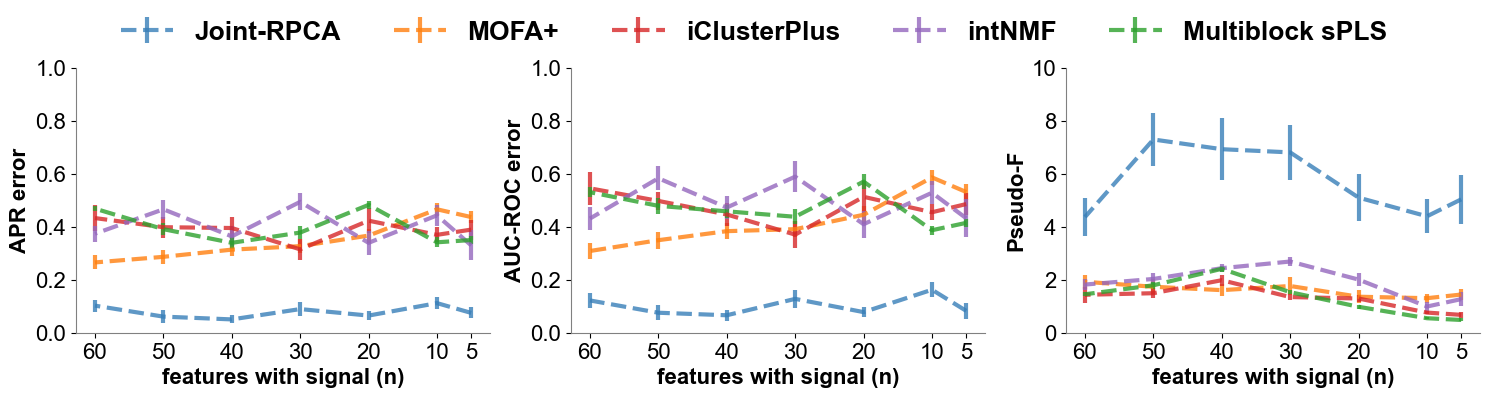

In [6]:
apr_all_df_subset = apr_all_df[apr_all_df.ninduced!=2].copy()
roc_all_df_subset = roc_all_df[roc_all_df.ninduced!=2].copy()
permanova_all_df_subset = permanova_all_df[permanova_all_df.ninduced!=2].copy()

fig, axn = plt.subplots(1, 3, figsize=(15, 3.5))

for projection_, apr_all_df_subset_ in apr_all_df_subset.groupby('method'):
    apr_all_df_subset_grp = apr_all_df_subset_.groupby('ninduced')
    axn[0].errorbar(apr_all_df_subset_grp.mean(numeric_only=True).index.values,
                    apr_all_df_subset_grp.mean(numeric_only=True)['apr_error'].values,
                    yerr=apr_all_df_subset_grp.sem(numeric_only=True)['apr_error'].values,
                    label=projection_, lw=3, alpha=0.8, ls='--', c=cmap_method[projection_])

for projection_, roc_all_df_subset_ in roc_all_df_subset.groupby('method'):
    roc_all_df_subset_grp = roc_all_df_subset_.groupby('ninduced')
    axn[1].errorbar(roc_all_df_subset_grp.mean(numeric_only=True).index.values,
                    roc_all_df_subset_grp.mean(numeric_only=True)['roc_error'].values,
                    yerr=roc_all_df_subset_grp.sem(numeric_only=True)['roc_error'].values,
                    label=projection_, lw=3, alpha=0.8, ls='--', c=cmap_method[projection_])

for projection_, permanova_all_df_subset_ in permanova_all_df_subset.groupby('method'):
    permanova_all_df_grp = permanova_all_df_subset_.groupby('ninduced')
    axn[2].errorbar(permanova_all_df_grp.mean(numeric_only=True).index.values,
                    permanova_all_df_grp.mean(numeric_only=True)['f_stat'].values,
                    yerr=permanova_all_df_grp.sem(numeric_only=True)['f_stat'].values,
                    label=projection_, lw=3, alpha=0.8, ls='--', c=cmap_method[projection_])
   
axn[0].set_ylabel('APR error', fontname='Arial',
                  color='black', weight='bold', fontsize=16)
axn[1].set_ylabel('AUC-ROC error', fontname='Arial',
                  color='black', weight='bold', fontsize=16)
axn[2].set_ylabel('Pseudo-F', fontname='Arial',
                  color='black', weight='bold', fontsize=16)

for ax in axn:
    ax.invert_xaxis()
    ax.set_xlabel('features with signal (n)',
                  color='black', fontname='Arial',
                  weight='bold', fontsize=16)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(16)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_horizontalalignment('center')
        tick.set_fontsize(16)

    # make x ticks evenly spaced
    true_densities = [x for x in n_induced_idx if x != 2]
    ax.set_xticks(true_densities)

plt.tight_layout()

# generate legend from last iterations     
handles, labels = axn[2].get_legend_handles_labels()
labels = [l_.replace('MOFA', 'MOFA+') for l_ in labels]
labels = [l_.replace('mixOmics', 'Multiblock sPLS') for l_ in labels]
labels = [l_.replace('iCluster', 'iClusterPlus') for l_ in labels]

legend = axn[0].legend(handles, labels,
                       loc=2, bbox_to_anchor=(0.05, 1.27),
                        prop={'size':19, 'weight':'bold', 'family': 'Arial'},
                        fancybox=False, framealpha=.0,
                        ncol=5, markerscale=1.5)
legend.get_title().set_fontsize('16')

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
    
axn[0].set_ylim(0, 1)
axn[1].set_ylim(0, 1)
axn[2].set_ylim(0, 10)

plt.savefig("../../results/supp-fig3A.pdf",
            dpi=600, bbox_inches='tight', 
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig("../../results/supp-fig3A.png",
            dpi=600, bbox_inches='tight', 
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [7]:
#create table with statistical tests
all_n_pvals = pd.DataFrame()
for n_ind in n_induced_idx:

    apr_d_ = apr_all_df[apr_all_df.ninduced==n_ind].copy()
    roc_d_ = roc_all_df[roc_all_df.ninduced==n_ind].copy()
    permanova_d_ = permanova_all_df[permanova_all_df.ninduced==n_ind].copy()

    apr_d_plist = []
    roc_d_plist = []
    per_d_plist = []
    comparison_lst = []

    #now, compare Joint-RPCA vs. other methods
    for method_, label_ in zip(['MOFA', 'iCluster', 'intNMF', 'mixOmics'],
                               ['MOFA+', 'iClusterPlus', 'intNMF', 'Multiblock sPLS']):
        
        _, p_apr = mannwhitneyu(apr_d_[apr_d_.method == 'Joint-RPCA']['apr_error'].values,
                                apr_d_[apr_d_.method == method_]['apr_error'].values)
        _, p_roc = mannwhitneyu(roc_d_[roc_d_.method == 'Joint-RPCA']['roc_error'].values,
                                roc_d_[roc_d_.method == method_]['roc_error'].values)
        _, p_per = mannwhitneyu(permanova_d_[permanova_d_.method == 'Joint-RPCA']['f_stat'].values,
                                permanova_d_[permanova_d_.method == method_]['f_stat'].values)
        comparison_ = 'Joint-RPCA vs. %s' % label_

        apr_d_plist.append(p_apr)
        roc_d_plist.append(p_roc)
        per_d_plist.append(p_per)
        comparison_lst.append(comparison_)

    n_pvals = pd.DataFrame({'Comparison': comparison_lst, 
                            'APR Error': apr_d_plist,
                            'AUC-ROC Error': roc_d_plist,
                            'Pseudo-F': per_d_plist})
    n_pvals['N Induced'] = '%s features' % n_ind
    
    all_n_pvals = pd.concat([all_n_pvals, n_pvals])

#reorder columns:
all_n_pvals = all_n_pvals[['N Induced', 'Comparison', 'APR Error',
                           'AUC-ROC Error', 'Pseudo-F']]
#save results
all_n_pvals.to_csv('../../results/supp-table-2-lowrank-sims-pvals.csv', index=False)

### TP/TN Feature Selection

In [8]:
#x axis: number of hits, y axis: number of true positives
joint_feat_metrics = pd.DataFrame()

for d_ in n_induced_idx:

    omic_feat_ids = np.concatenate(feat_induced_dict[d_])
    
    for fold_ in range(1,11):

        ord_samples = joint_ord_results[(d_, fold_)][0].copy()
        ord_ranks = joint_ord_results[(d_, fold_)][1].copy()

        #first, identify the best pc that separates groups of interest
        p_vals_ = {}
        for pc_ in ['PC1','PC2','PC3']:
            f_, p_ = mannwhitneyu(ord_samples[ord_samples.groups == 'g0'].dropna(subset=[pc_])[pc_].values,
                                  ord_samples[ord_samples.groups != 'g0'].dropna(subset=[pc_])[pc_].values)
            p_vals_[pc_] = round(p_, 5)
        best_pc = min(p_vals_, key=p_vals_.get)
        #print(p_vals_, best_pc)

        best_ranks = ord_ranks.sort_values(by=best_pc, ascending=False)
        best_ranks = best_ranks.reset_index().rename(columns={'index':'FeatureID'})
        best_ranks = best_ranks.reset_index().rename(columns={'index':'Rank'})
        best_ranks['Rank'] += 1
        best_ranks.set_index('FeatureID', inplace=True)

        nhits = [5, 10, 15, 20, 25, 50, 100, 150, 200]
        tp_lst = []
        prec_lst = []
        rec_lst = []
        
        # get top and bottom n features
        for n_ in nhits:
            top_ = best_ranks.head(n_).index
            bottom_ = best_ranks.tail(n_).index
            feats_ = list(top_) + list(bottom_)
            total_n = len(feats_)
            #calculate metrics
            tp_ = set(omic_feat_ids) & set(feats_) #number of TPs
            prec_ = len(tp_)/total_n #precision
            rec_ = len(tp_)/len(omic_feat_ids) #recall
            #save
            tp_lst.append(len(tp_))
            prec_lst.append(prec_)
            rec_lst.append(rec_)

        metric_df_ = pd.DataFrame({"K hits": [x*2 for x in nhits],
                                   "TP": tp_lst, "Precision": prec_lst,
                                   "Recall": rec_lst})
        metric_df_['Fold'] = fold_
        metric_df_['Induced n'] = d_
        metric_df_['Method'] = 'Joint-RPCA'
        joint_feat_metrics = pd.concat([joint_feat_metrics, metric_df_])

In [9]:
#mofa rankings
mofa_ranks = {}
rename_cols = {'Factor1': 'PC1', 'Factor2': 'PC2', 'Factor3': 'PC3'}

for f in range(1,11):
    for density in n_induced_idx:
        #print("MOFA+ result: Overlap %s Projection on %s" % (density, view_use))
        mofa_w_ = pd.read_csv(
            "../../data/simulations/lowrank/mofa_fsignal/%i.weights.model.fsignal%s.csv" % (f, density), index_col=0)
        df_ = pd.pivot_table(columns='factor', values='value', index='feature', data=mofa_w_)
        #add to metadata for ML
        df_.rename(columns=rename_cols,inplace=True)
        mofa_ranks[(f, density)] = df_

mofa_train_ord = {}
for f in range(1,11):
    for density in n_induced_idx:
        #print("MOFA+ result: Overlap %s Projection on %s" % (density, view_use))
        mofa_w_ = pd.read_csv(
            "../../data/simulations/lowrank/mofa_fsignal/%i.factors.model.fsignal%s.csv" % (f, density), index_col=0)
        df_ = pd.pivot_table(columns='factor', values='value', index='sample', data=mofa_w_)
        df_.rename(columns=rename_cols,inplace=True)
        #add metadata info
        df_ = pd.concat([df_, metadata], axis=1).dropna(subset='PC1')
        mofa_train_ord[(f, density)] = df_

In [10]:
#repeat for MOFA
mofa_feat_metrics = pd.DataFrame()
for d_ in n_induced_idx:

    omic_feat_ids = np.concatenate(feat_induced_dict[d_])
    #print(len(omic_feat_ids))

    for fold_ in range(1,11):

        ord_samples_m = mofa_train_ord[(fold_, d_)].copy()
        ord_ranks_m = mofa_ranks[(fold_, d_)].copy()

        #first, identify the best pc that separates groups of interest
        p_vals_ = {}
        pc_cols = [x for x in ord_samples_m.columns if 'PC' in x]
        for pc_ in pc_cols:
            f_, p_ = mannwhitneyu(ord_samples_m[ord_samples_m.groups == 'g0'].dropna(subset=[pc_])[pc_].values,
                                  ord_samples_m[ord_samples_m.groups != 'g0'].dropna(subset=[pc_])[pc_].values)
            p_vals_[pc_] = round(p_, 5)
        best_pc = min(p_vals_, key=p_vals_.get)
        #print(p_vals_, best_pc)

        best_ranks_m = ord_ranks_m.sort_values(by=best_pc, ascending=False)
        best_ranks_m = best_ranks_m.reset_index().rename(columns={'feature':'FeatureID'})
        best_ranks_m = best_ranks_m.reset_index().rename(columns={'index':'Rank'})
        #display(best_ranks_m.head())
        best_ranks_m['Rank'] += 1
        best_ranks_m.set_index('FeatureID', inplace=True)

        nhits = [5, 10, 15, 20, 25, 50, 100, 150, 200]
        tp_lst = []
        prec_lst = []
        rec_lst = []
        
        # get top and bottom n features
        for n_ in nhits:
            top_ = best_ranks_m.head(n_).index
            bottom_ = best_ranks_m.tail(n_).index
            feats_ = list(top_) + list(bottom_)
            #print(feats_)
            total_n = len(feats_)
            #calculate metrics
            tp_ = set(omic_feat_ids) & set(feats_) #number of TPs
            prec_ = len(tp_)/total_n #precision
            rec_ = len(tp_)/len(omic_feat_ids) #recall
            #save
            tp_lst.append(len(tp_))
            prec_lst.append(prec_)
            rec_lst.append(rec_)

        metric_df_m = pd.DataFrame({"K hits": [x*2 for x in nhits],
                                    "TP": tp_lst, "Precision": prec_lst,
                                    "Recall": rec_lst})
        metric_df_m['Fold'] = fold_
        metric_df_m['Induced n'] = d_
        metric_df_m['Method'] = 'MOFA'
        mofa_feat_metrics = pd.concat([mofa_feat_metrics, metric_df_m])

In [11]:
#concat metrics from both methods
feat_metrics_all = pd.concat([joint_feat_metrics, mofa_feat_metrics])
feat_metrics_all.reset_index(drop=True, inplace=True)
feat_metrics_all

,K hits,TP,Precision,Recall,Fold,Induced n,Method
0,10,5,0.500000,0.333333,1,5,Joint-RPCA
1,20,10,0.500000,0.666667,1,5,Joint-RPCA
2,30,13,0.433333,0.866667,1,5,Joint-RPCA
3,40,15,0.375000,1.000000,1,5,Joint-RPCA
4,50,15,0.300000,1.000000,1,5,Joint-RPCA
...,...,...,...,...,...,...,...
1255,50,24,0.480000,0.133333,10,60,MOFA
1256,100,48,0.480000,0.266667,10,60,MOFA
1257,200,89,0.445000,0.494444,10,60,MOFA
1258,300,124,0.413333,0.688889,10,60,MOFA


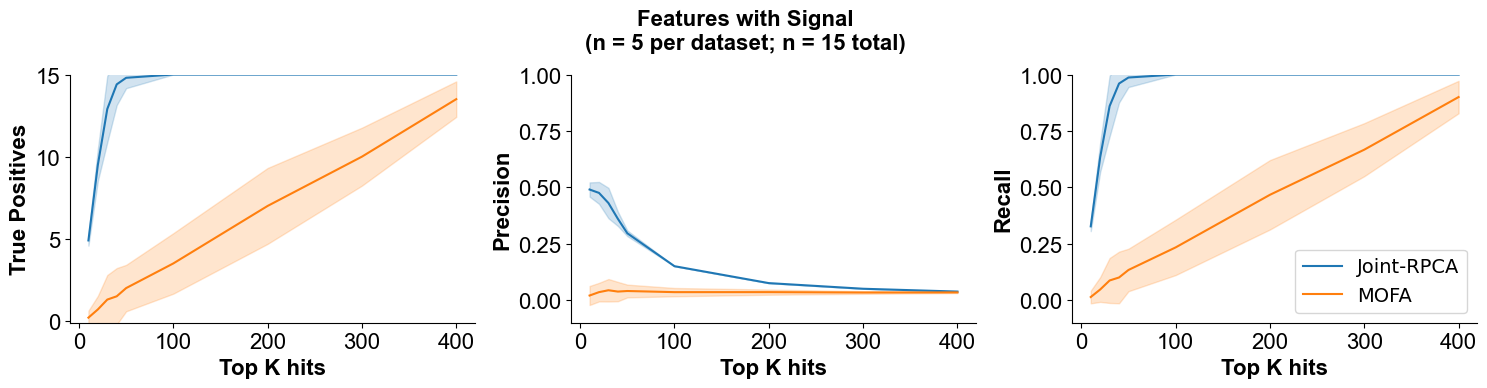

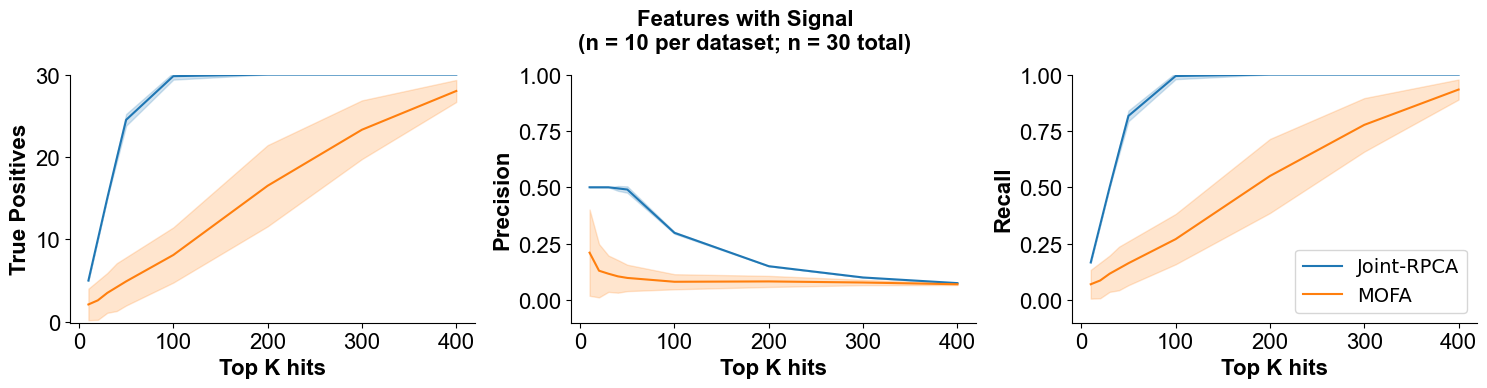

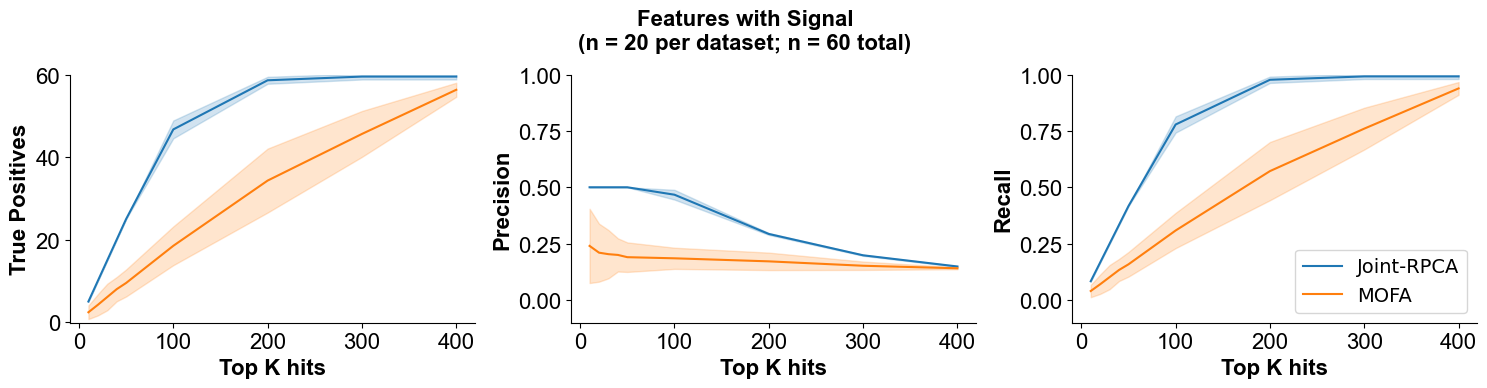

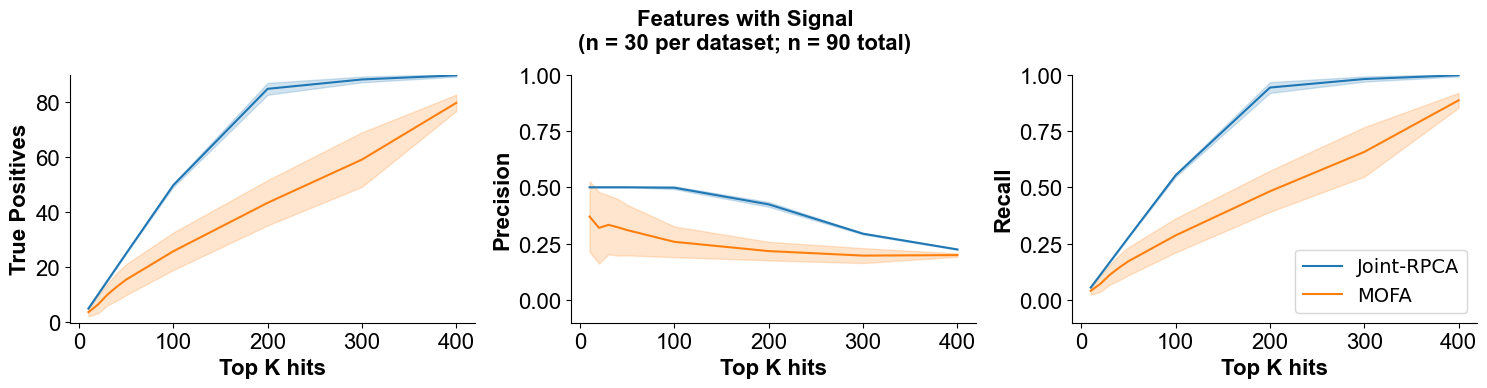

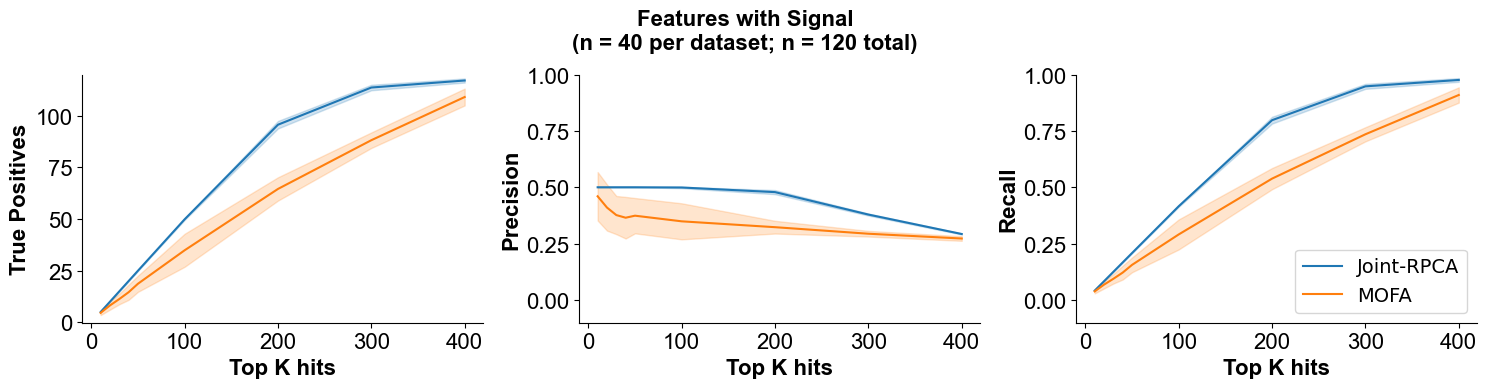

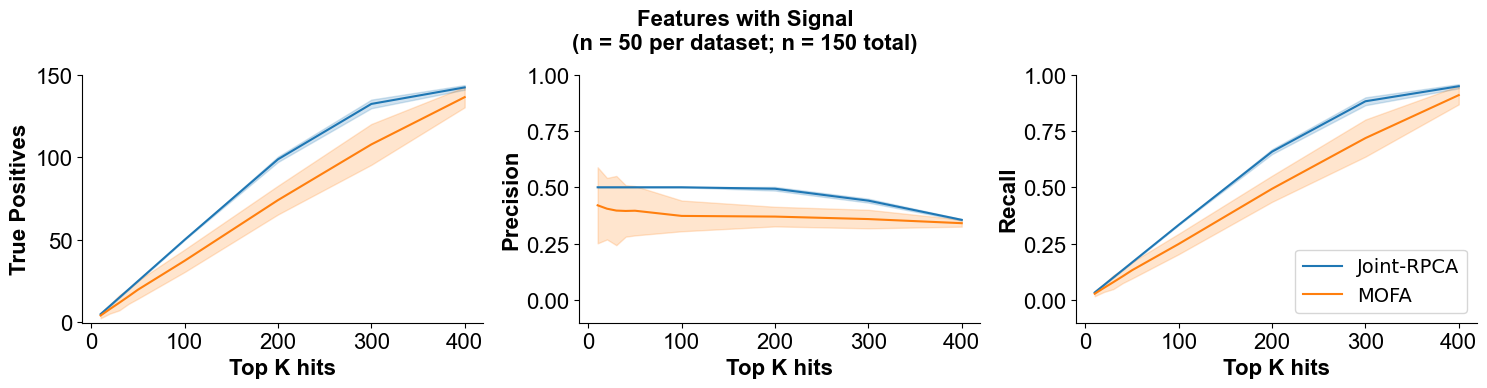

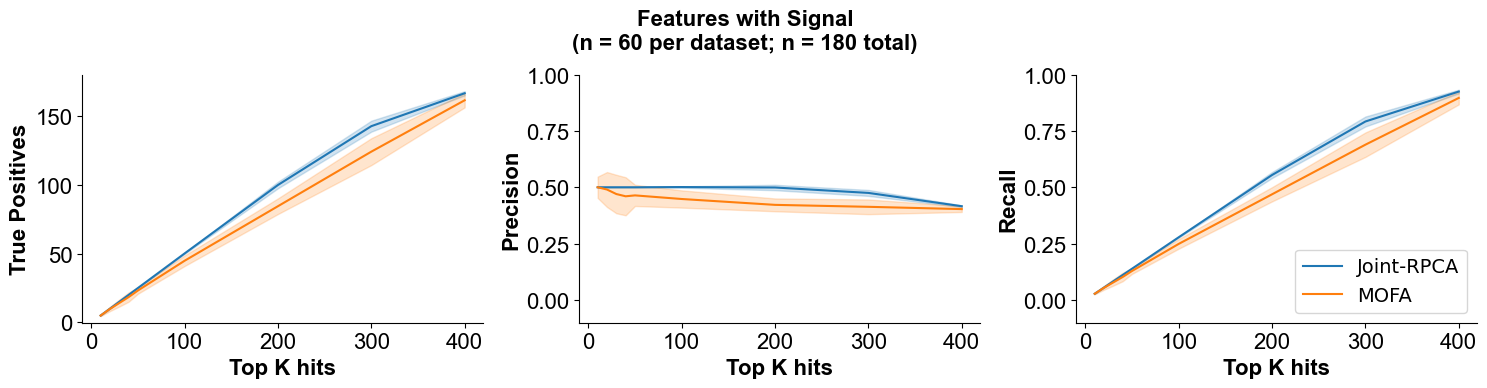

In [12]:
for nf_ in feat_metrics_all['Induced n'].unique():

    metrics_sub = feat_metrics_all[feat_metrics_all['Induced n']==nf_].copy()
    
    fig, axn = plt.subplots(1, 3, figsize=(15, 4))
    
    for ax, metric_ in zip(axn.flatten(), ['TP', 'Precision', 'Recall']):
        
        sns.lineplot(y=metric_, x='K hits', data=metrics_sub, ax=ax, hue='Method', ci='sd')
        sns.despine()
        
        if metric_ != 'Recall':
            ax.legend_.remove()
        else:
            ax.legend(loc='lower right', fontsize=14)

        ax.set_xlabel('Top K hits', color='black', weight='bold',
                      fontsize=16, fontname='Arial')
        ax.set_ylabel(metric_, color='black', weight='bold', 
                      fontsize=16, fontname='Arial')

        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_fontsize(16)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_horizontalalignment('center')
            tick.set_fontsize(16)
        ax.locator_params(axis='x', nbins=5)
        ax.locator_params(axis='y', nbins=5)
        
        if metric_ == 'TP':
            ax.set_ylim(-0.1, nf_*3)
            ax.set_ylabel('True Positives', color='black', 
                          weight='bold', fontsize=16, fontname='Arial')
        else:
            ax.set_ylim(-0.1, 1)
    
    plt.suptitle('Features with Signal\n(n = %s per dataset; n = %s total)'%(nf_, nf_*3), 
                 fontname='Arial', weight='bold', fontsize=16, y=0.96)
    plt.tight_layout()

    if nf_ in [5, 20, 50]:
        plt.savefig("../../results/supp-fig3B-%sfeats.pdf" % nf_,
                    dpi=600, bbox_inches='tight', 
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')
        plt.savefig("../../results/supp-fig3B-%sfeats.pdf" % nf_,
                    dpi=600, bbox_inches='tight', 
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')
    plt.show()

15


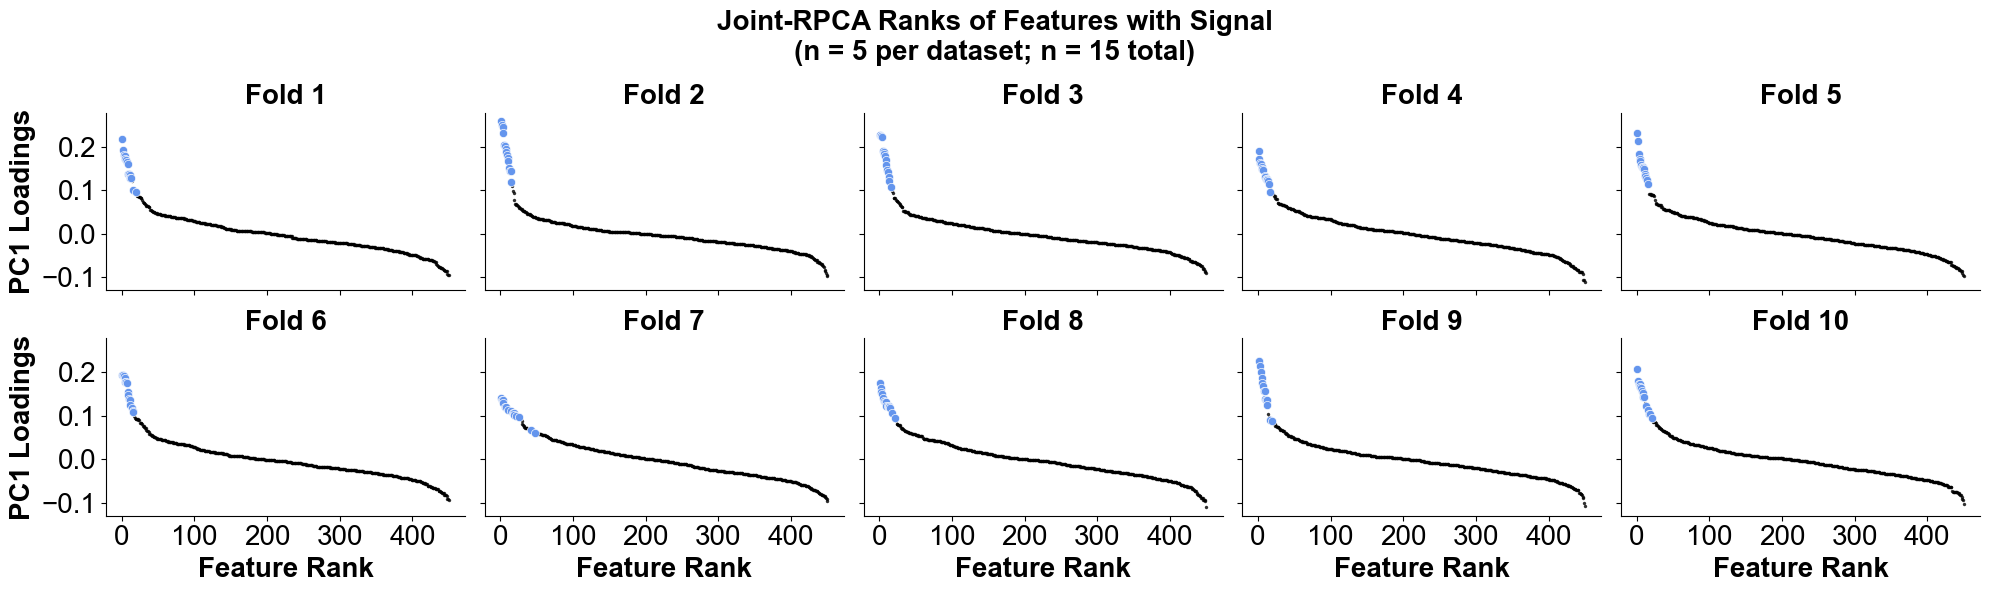

30


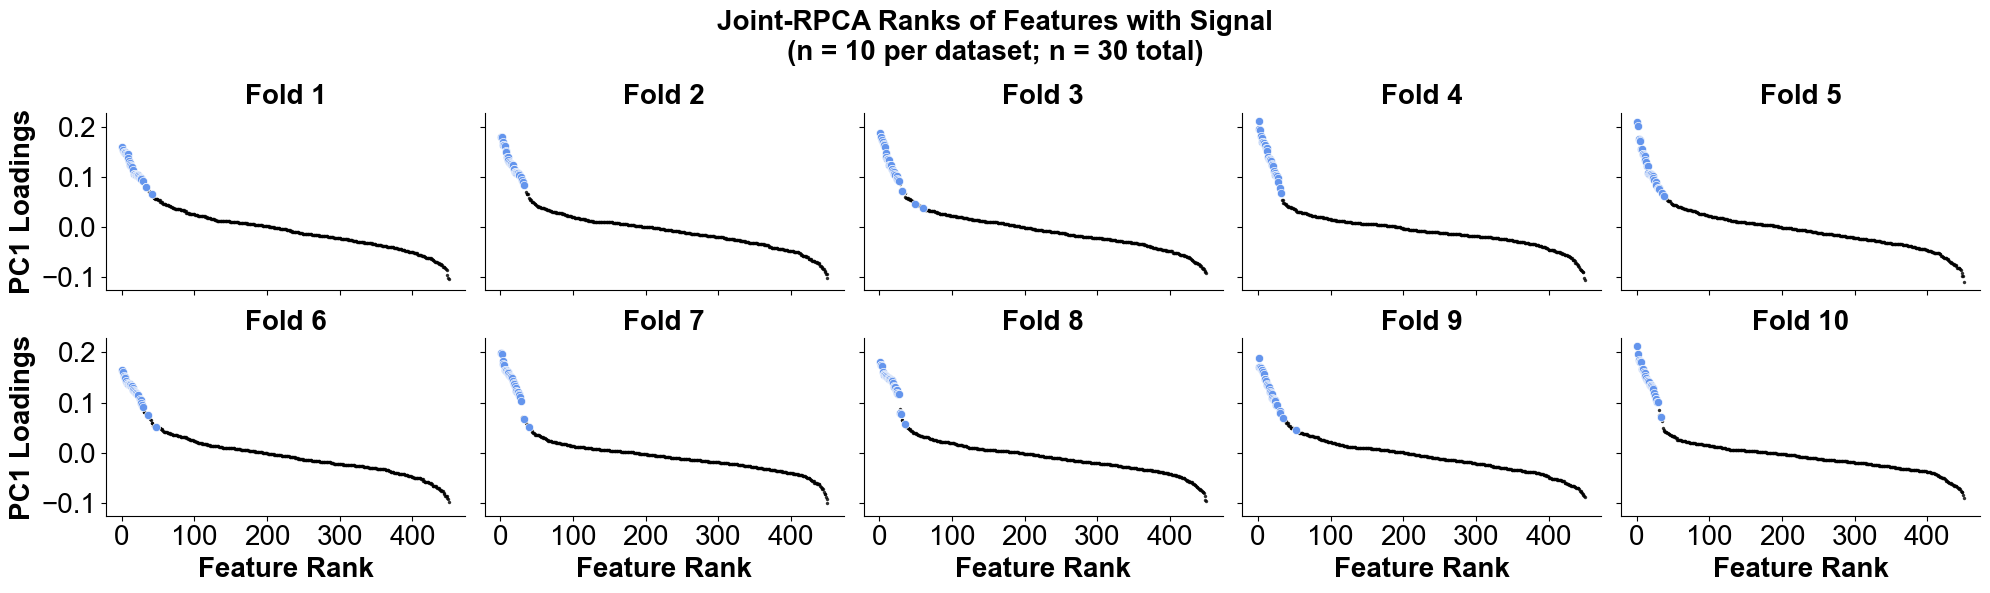

60


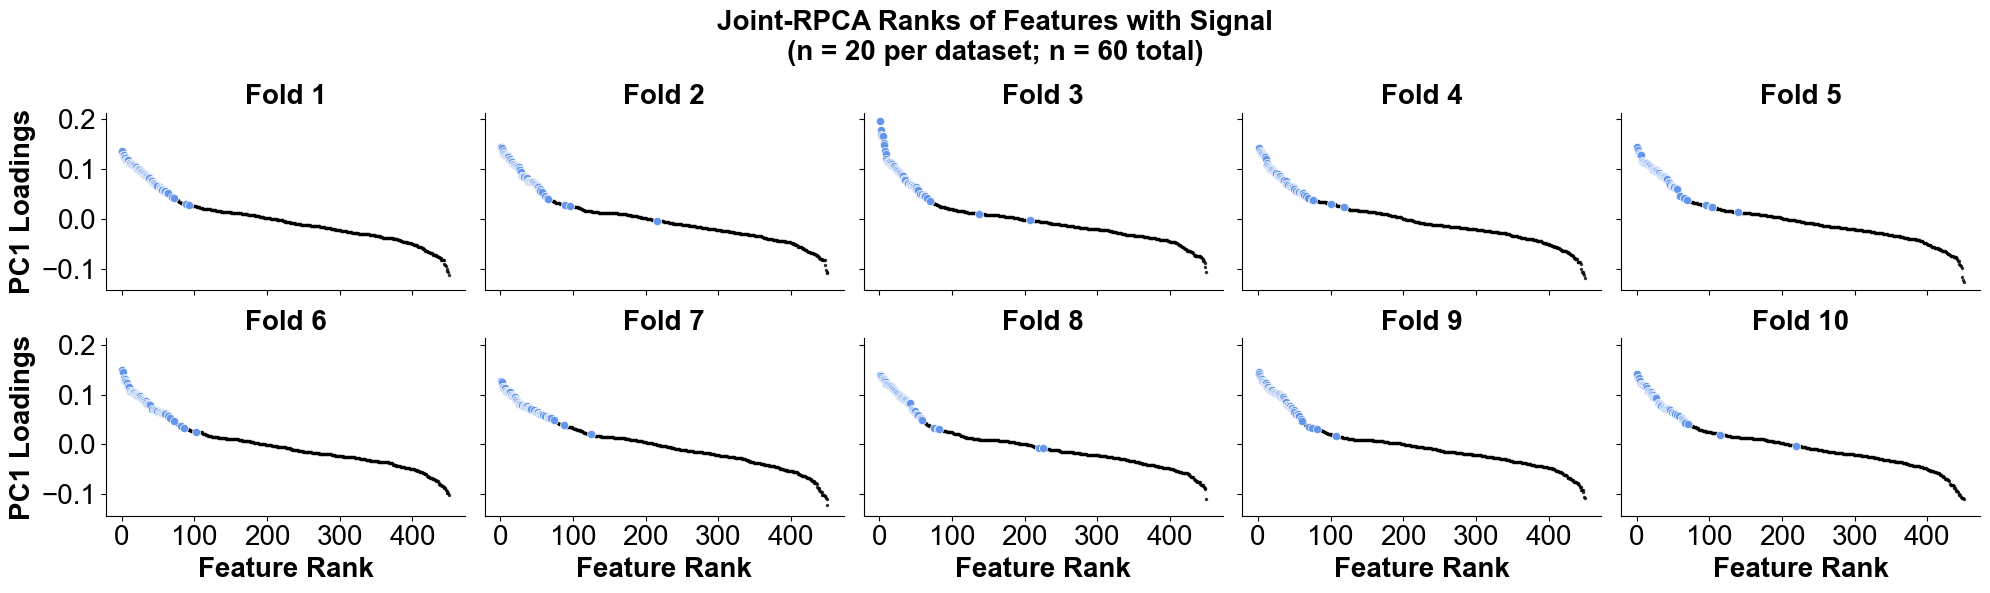

90


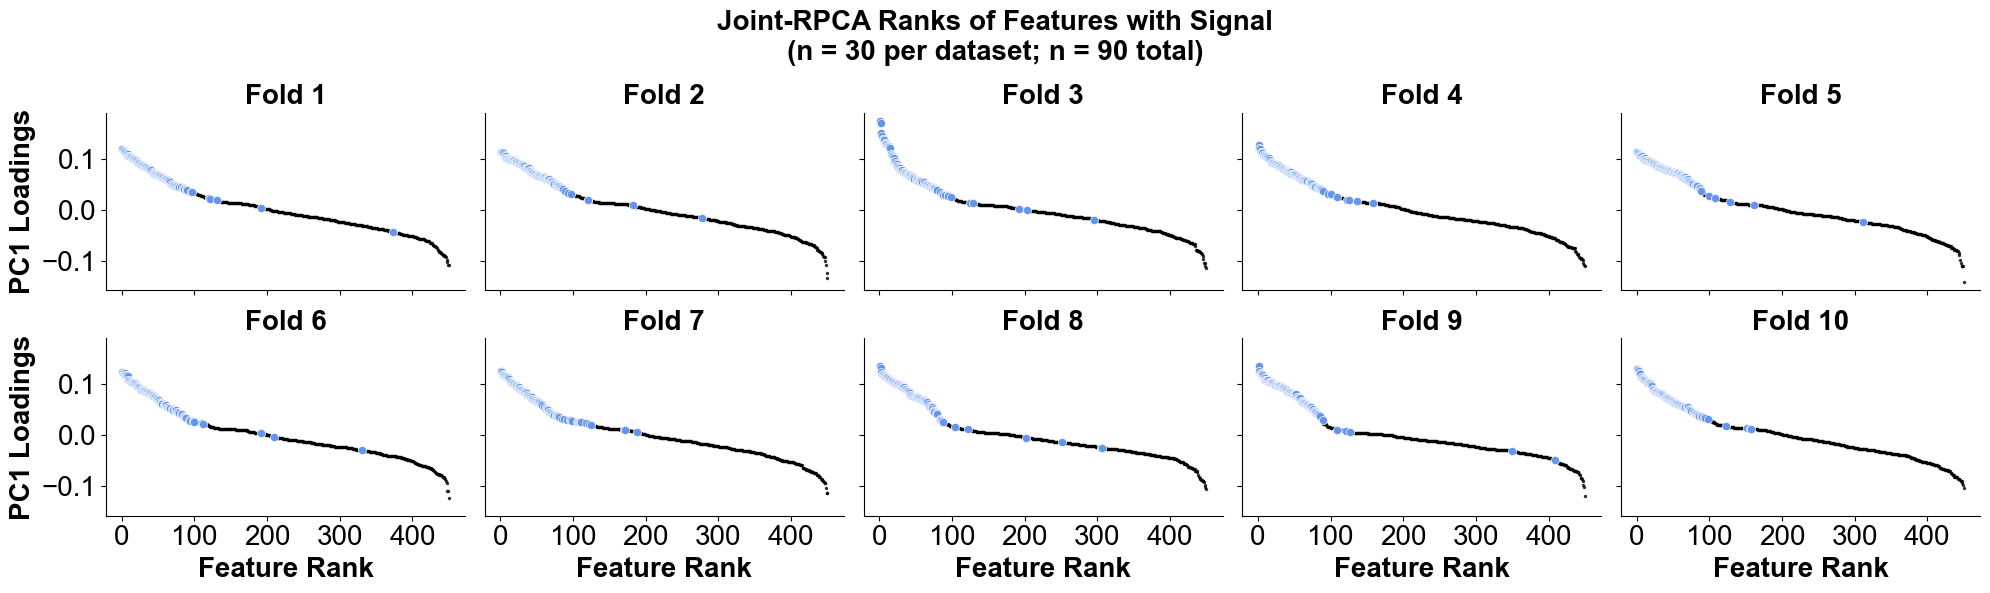

120


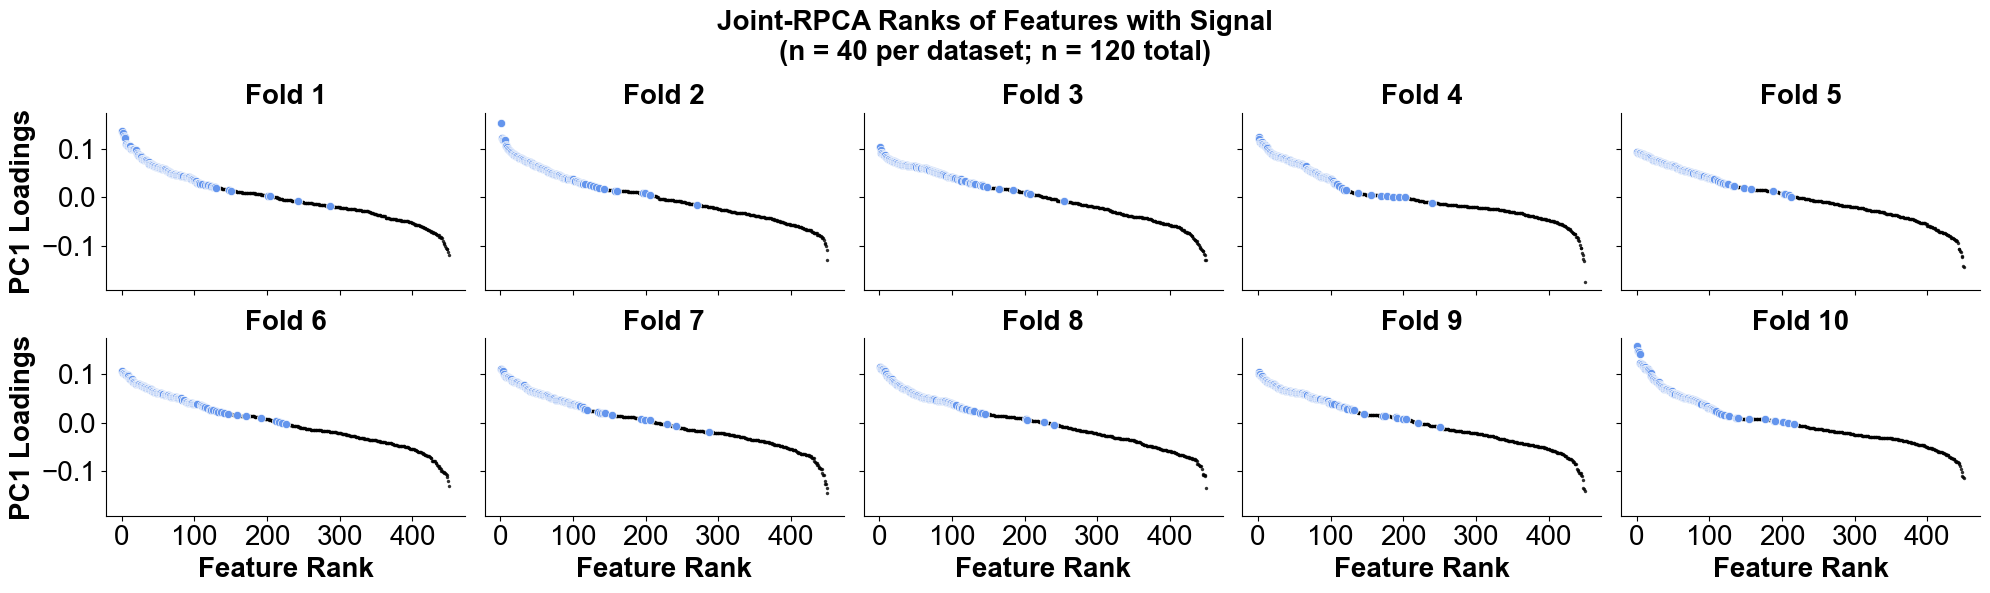

150


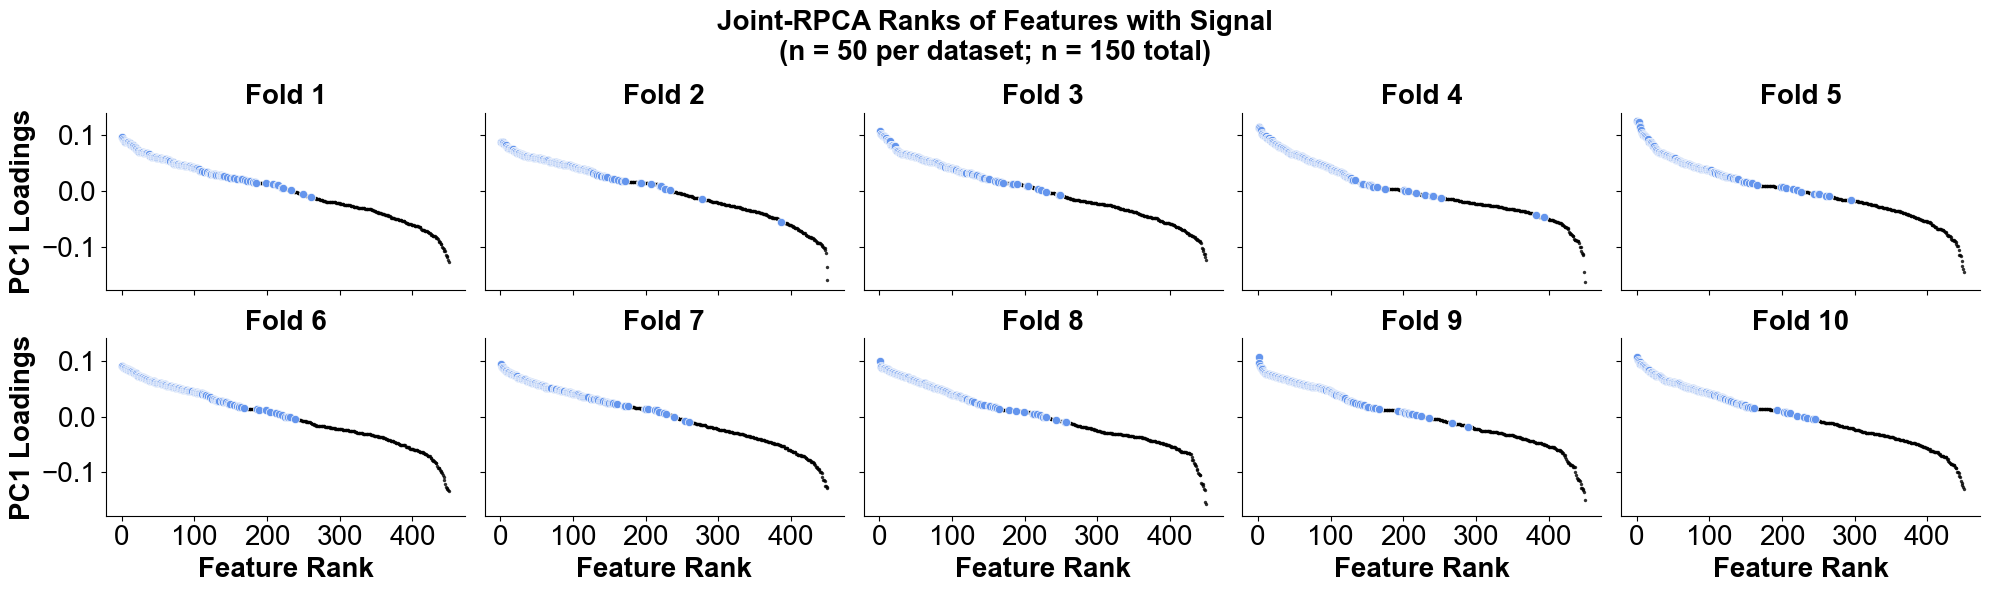

180


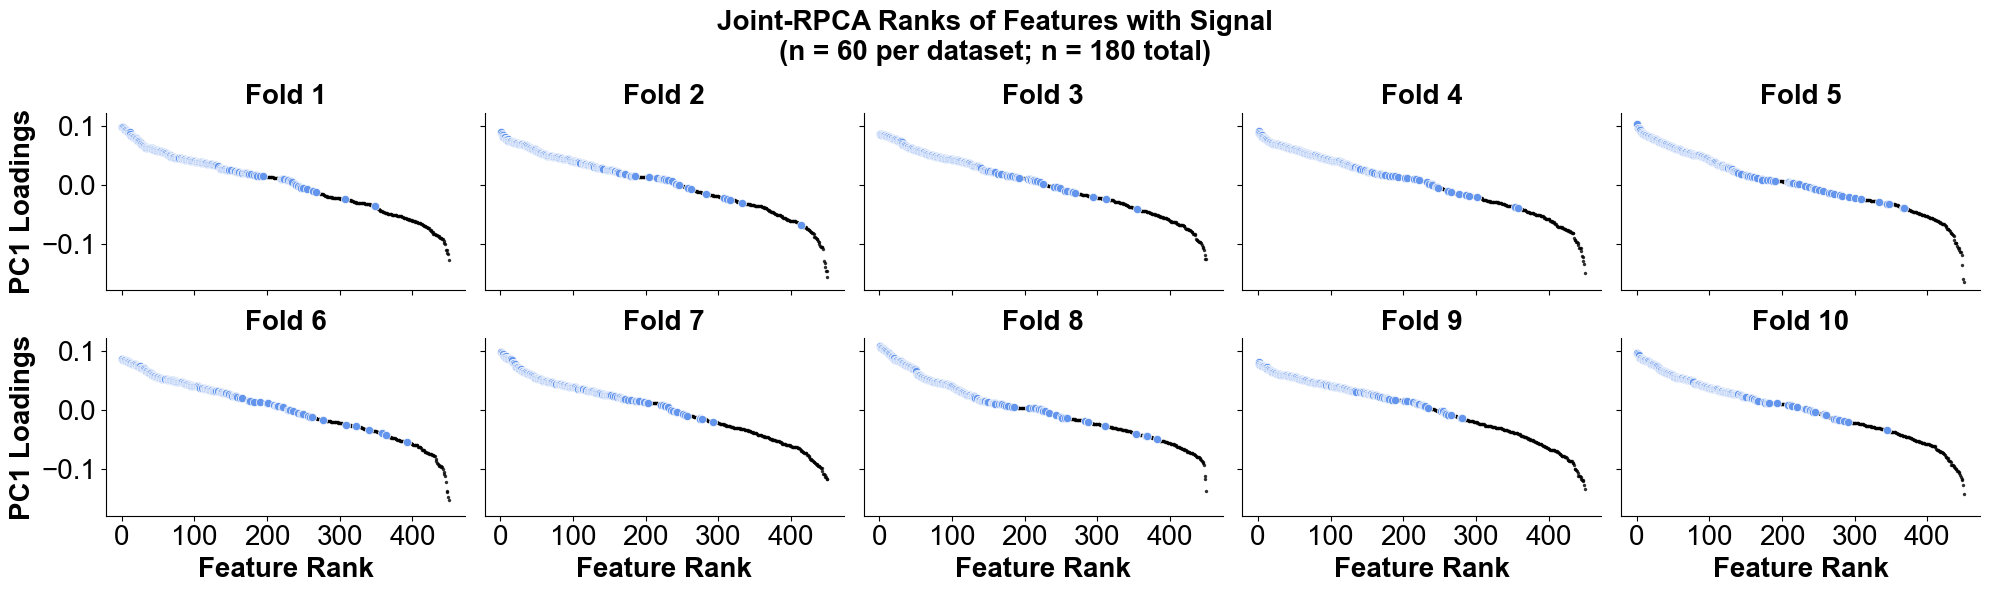

In [16]:
for n_induced in n_induced_idx:

    #get ground truth features (unique and shared per group)
    omic_feat_ids = np.concatenate(feat_induced_dict[n_induced])
    print(len(omic_feat_ids))

    #plotting
    fig, axn = plt.subplots(2, 5, figsize=(20, 6), sharex=True, sharey=True)

    for ax, fold_ in zip(axn.flatten(), range(1, 11)):
        
        ord_samples = joint_ord_results[(n_induced, fold_)][0].copy()
        ord_ranks = joint_ord_results[(n_induced, fold_)][1].copy()
        
        p_vals = {}
        for pc_ in ['PC1','PC2','PC3']:
            f_, p_ = mannwhitneyu(ord_samples[ord_samples.groups == 'g0'].dropna(subset=[pc_])[pc_].values,
                                  ord_samples[ord_samples.groups != 'g0'].dropna(subset=[pc_])[pc_].values)
            p_vals[pc_] = round(p_, 5)
        best_pc = min(p_vals, key=p_vals.get)
        #print(p_vals, best_pc)

        #all folds except for fold 10 are inverted (randomly)
        #fix this for consistency:
        if fold_ != 10:
            ord_ranks[best_pc] = ord_ranks[best_pc] * (-1)

        best_ranks = ord_ranks.sort_values(by=best_pc, ascending=False)
        best_ranks = best_ranks.reset_index().rename(columns={'index':'FeatureID'})
        best_ranks = best_ranks.reset_index().rename(columns={'index':'Rank'})
        best_ranks['Rank'] += 1
        best_ranks.set_index('FeatureID', inplace=True)
        
        sns.scatterplot(x='Rank', y=best_pc, s=5, color='black', alpha=0.8,
                        data=best_ranks, ax=ax, edgecolor='k')
        sns.scatterplot(x='Rank', y=best_pc, s=35, color='cornflowerblue', alpha=1,
                        data=best_ranks[best_ranks.index.isin(omic_feat_ids)], ax=ax)
        ax.set_xlabel('Feature Rank', color='black', weight='bold',
                      fontsize=20, fontname='Arial')
        ax.set_ylabel('%s Loadings' % best_pc, fontsize=20, fontweight='bold', fontname='Arial')
        ax.set_title("Fold %s" % fold_, color='black', weight='bold',
                      fontsize=20, fontname='Arial')
        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_fontsize(20)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_horizontalalignment('center')
            tick.set_fontsize(20)
        ax.locator_params(axis='x', nbins=5)
        ax.locator_params(axis='y', nbins=5)
        sns.despine()

    plt.suptitle('Joint-RPCA Ranks of Features with Signal\n(n = %s per dataset; n = %s total)' % (n_induced, n_induced*3),
                 fontsize=20, fontname='Arial', weight='bold')
    plt.tight_layout()

    if n_induced in [5, 20, 50]:
        plt.savefig("../../results/supp-fig3C-joint-rpca-%sfeats.pdf" % n_induced,
                    dpi=600, bbox_inches='tight', 
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')
        plt.savefig("../../results/supp-fig3C-joint-rpca-%sfeats.png" % n_induced,
                    dpi=600, bbox_inches='tight', 
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')
    plt.show()

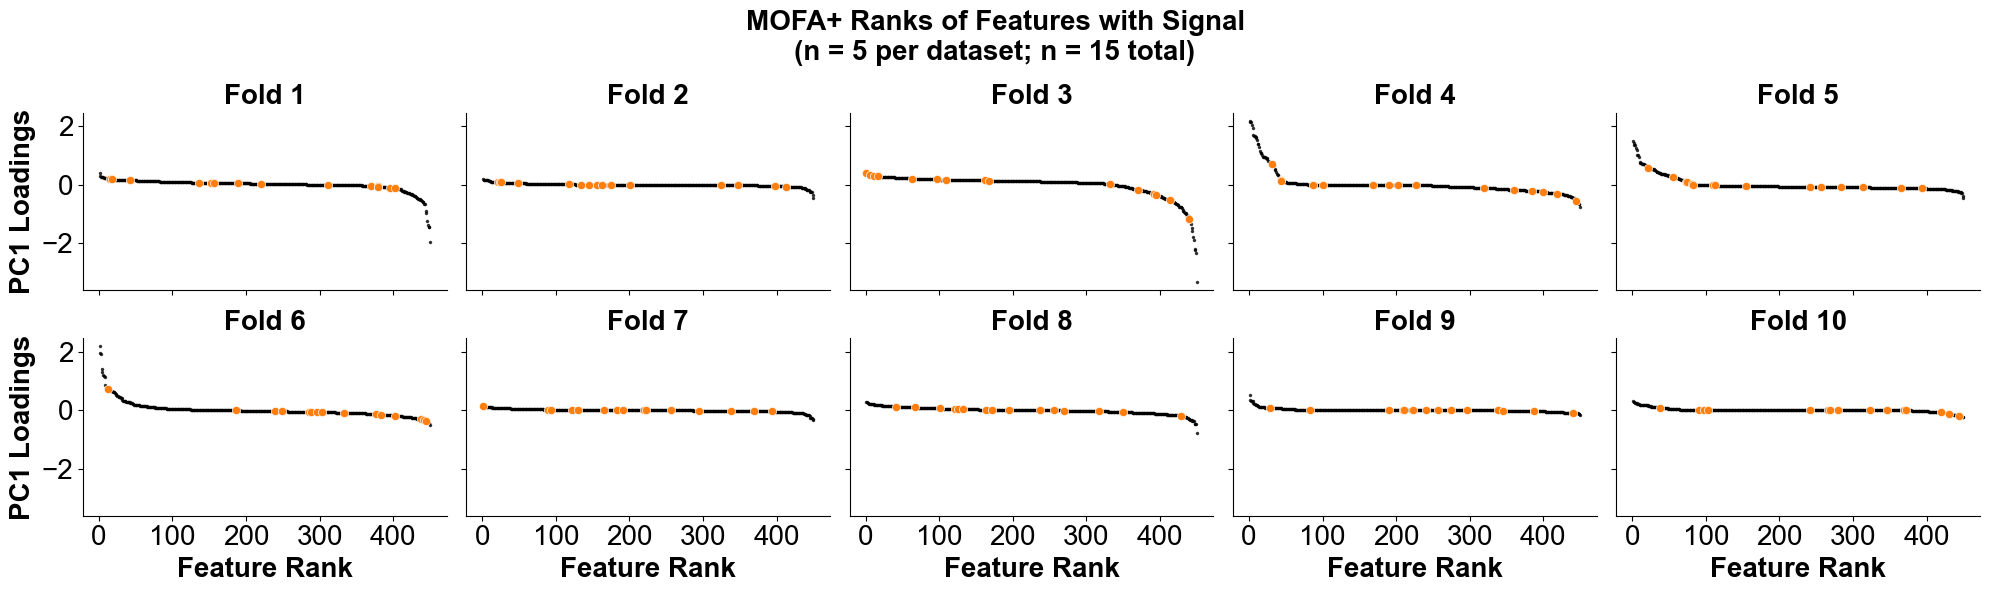

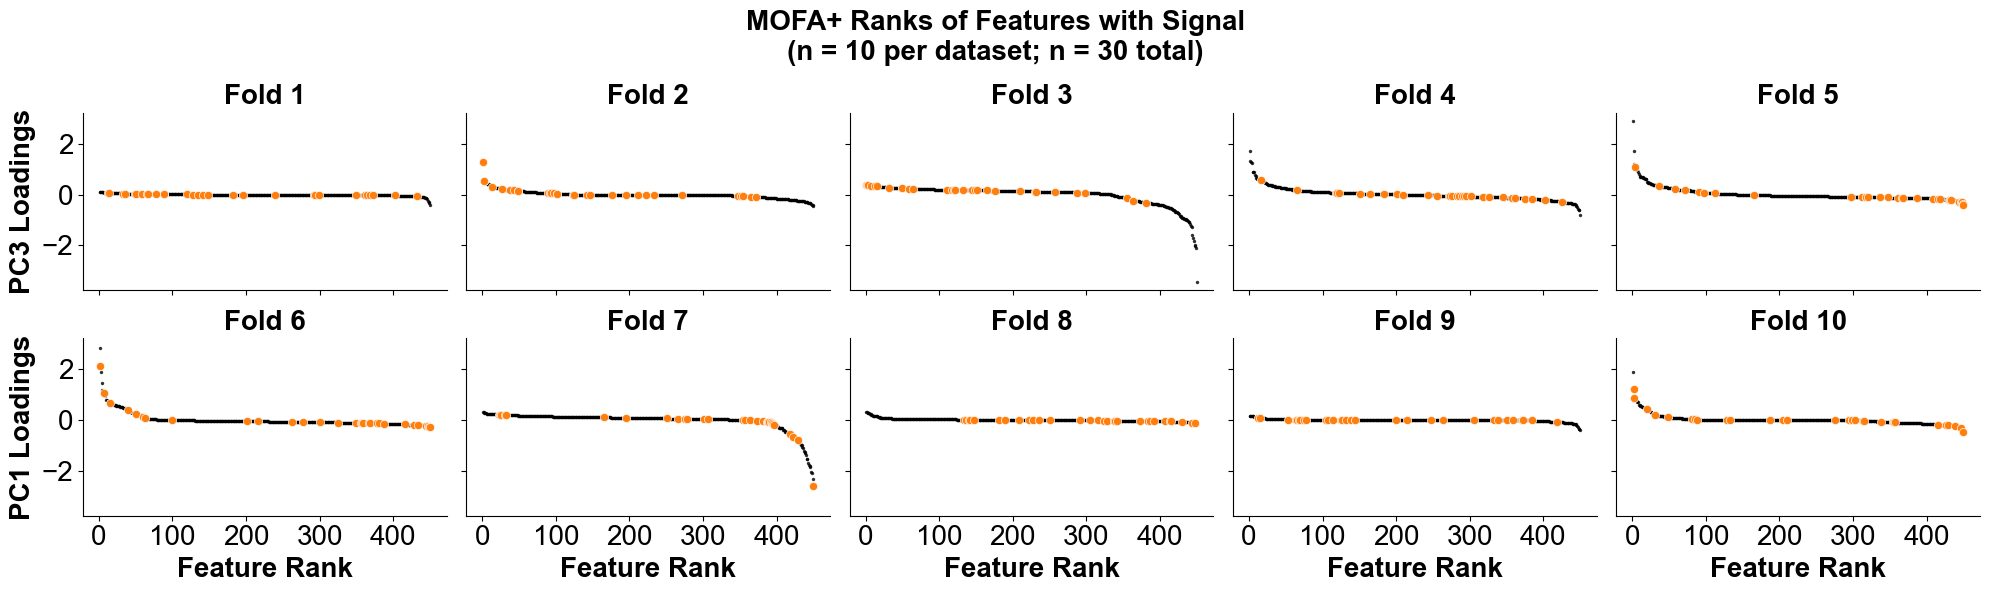

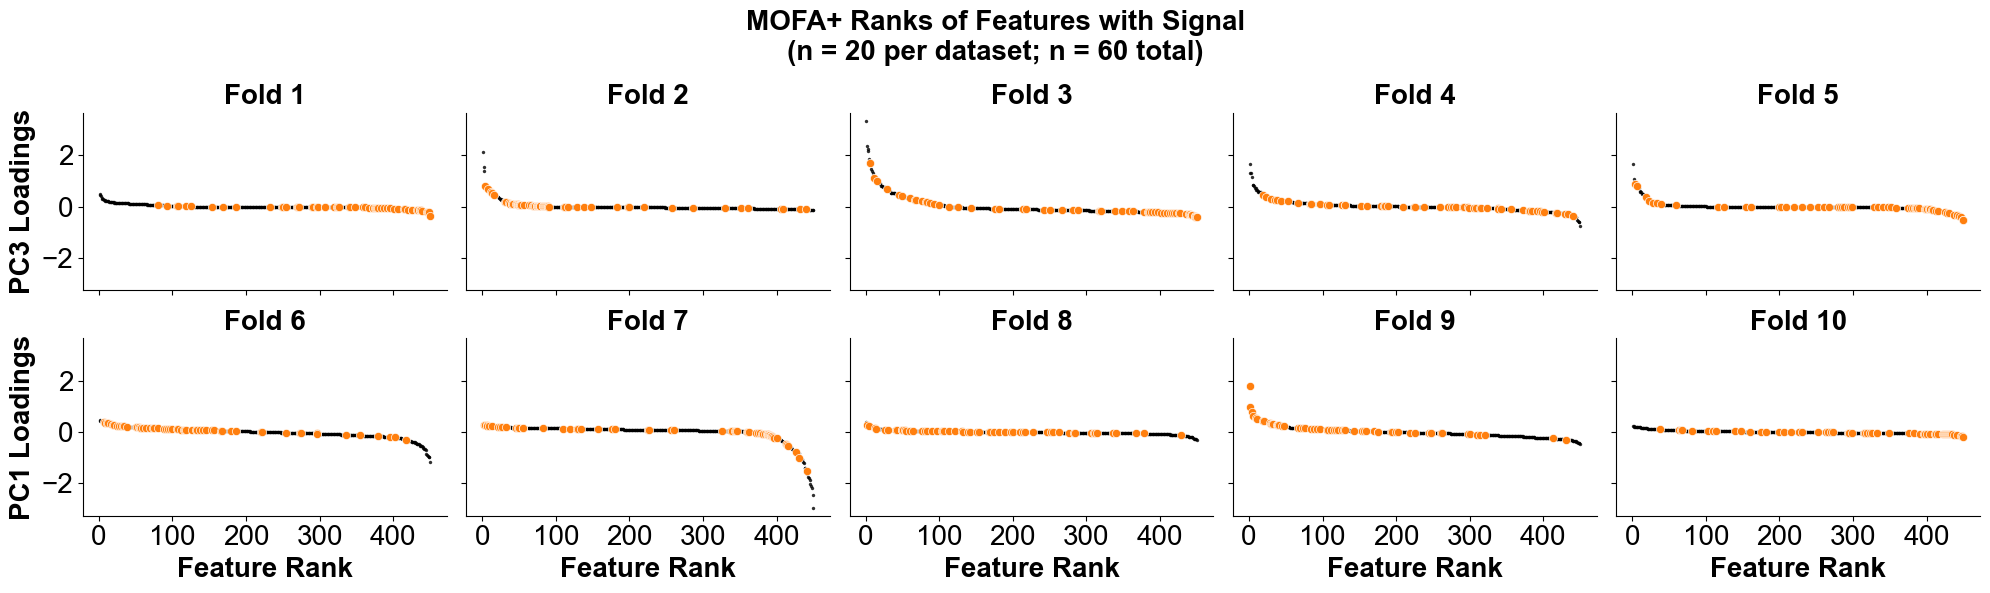

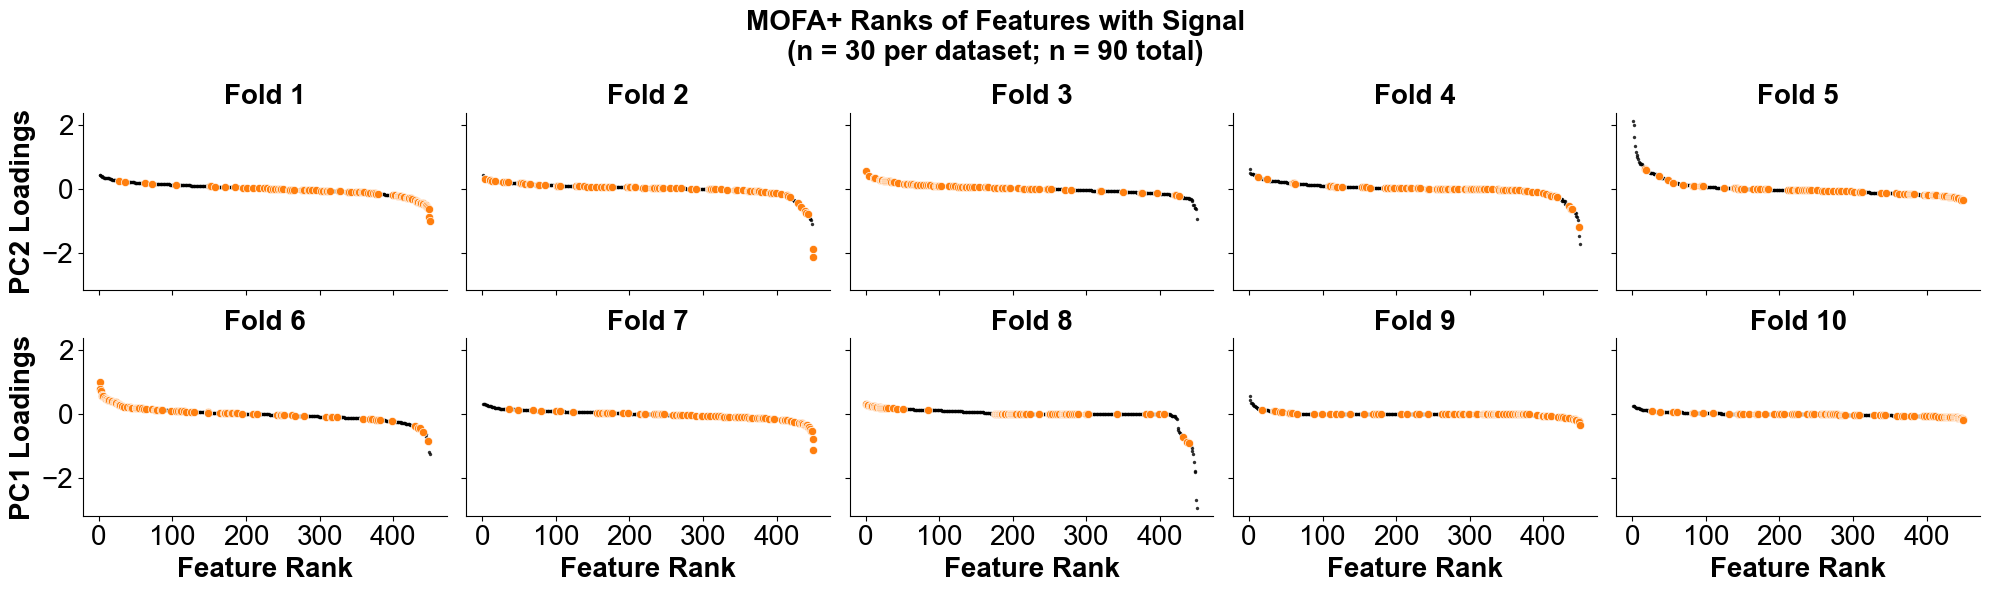

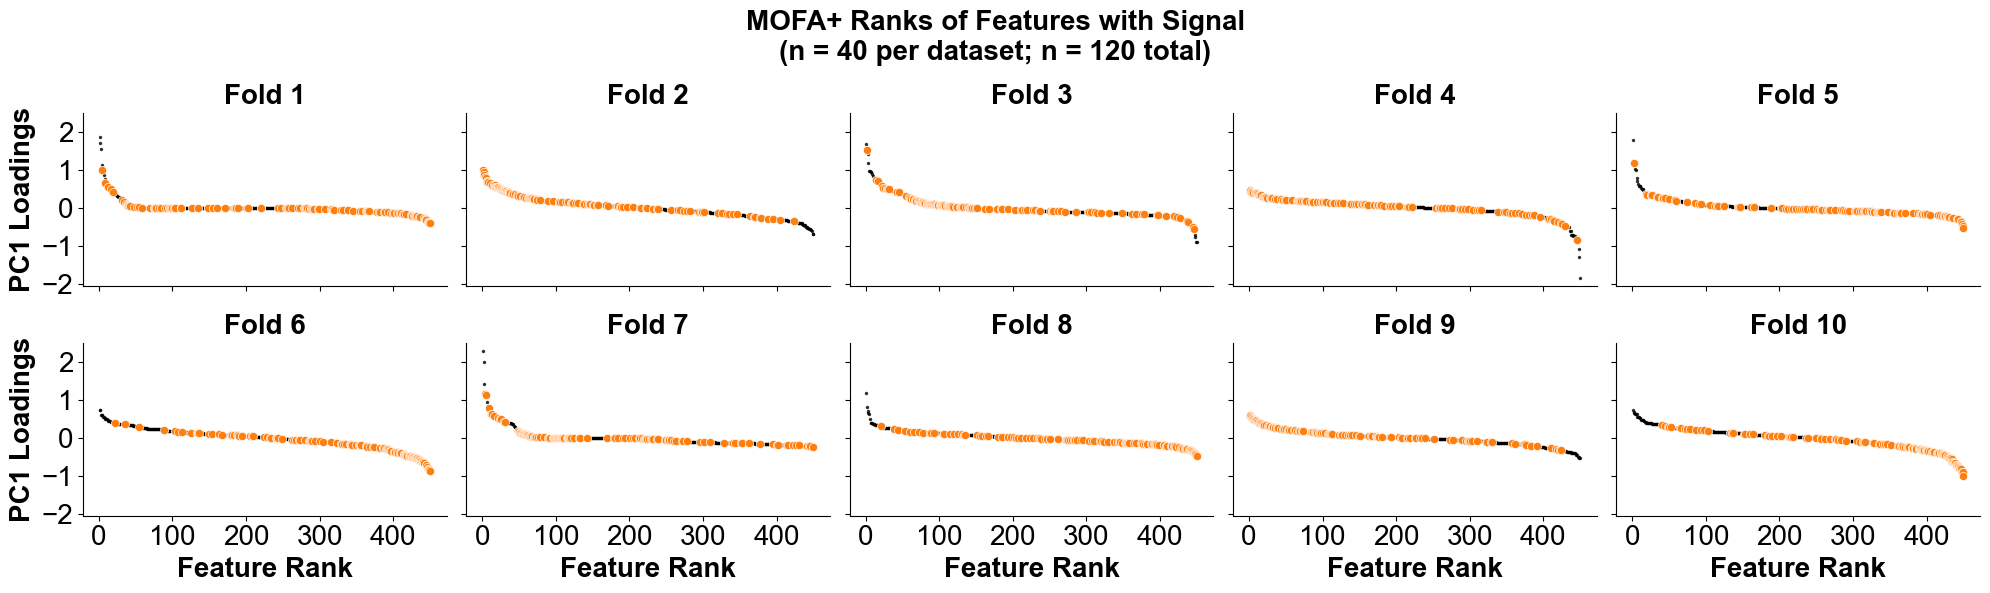

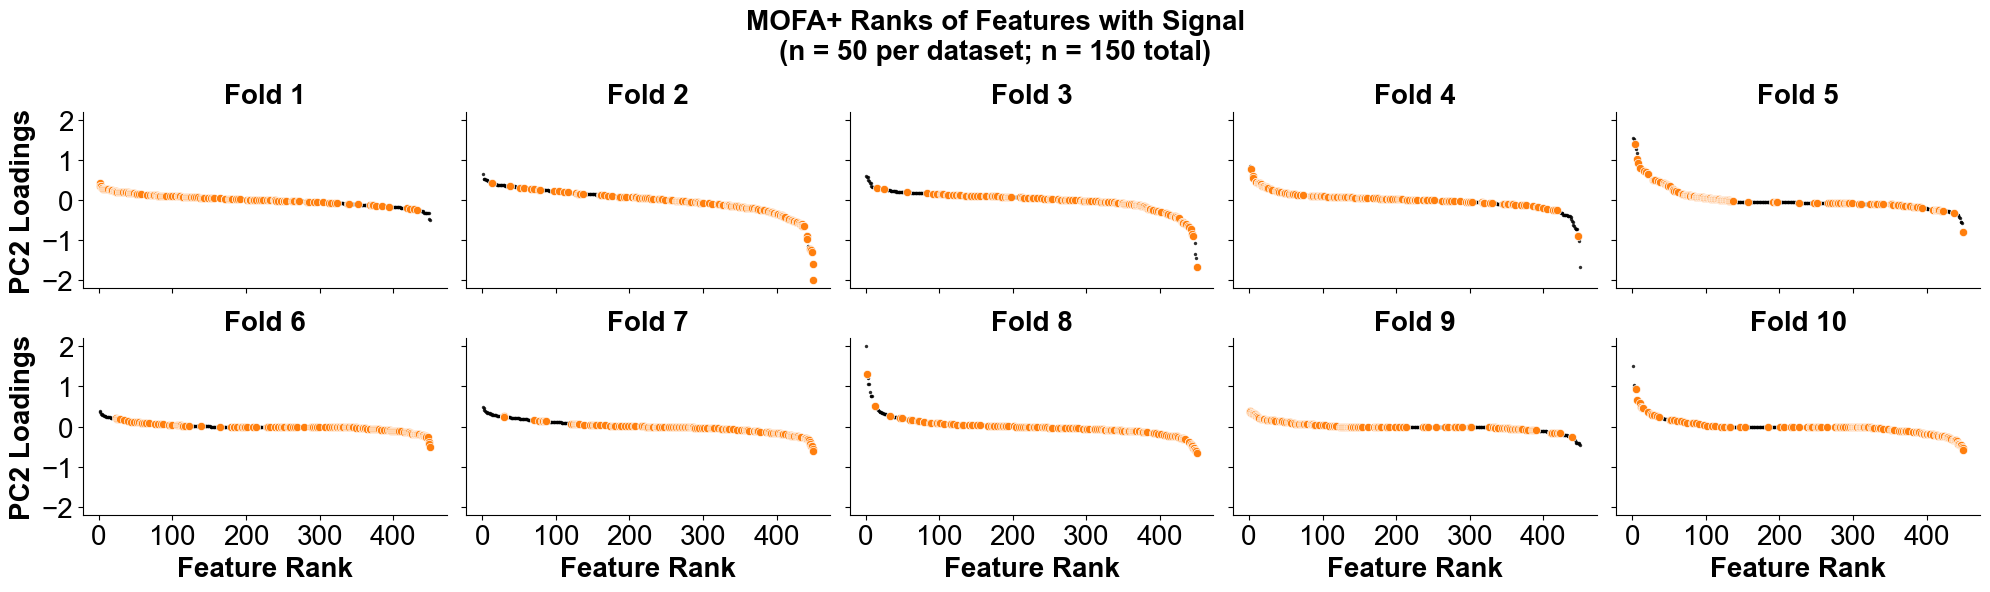

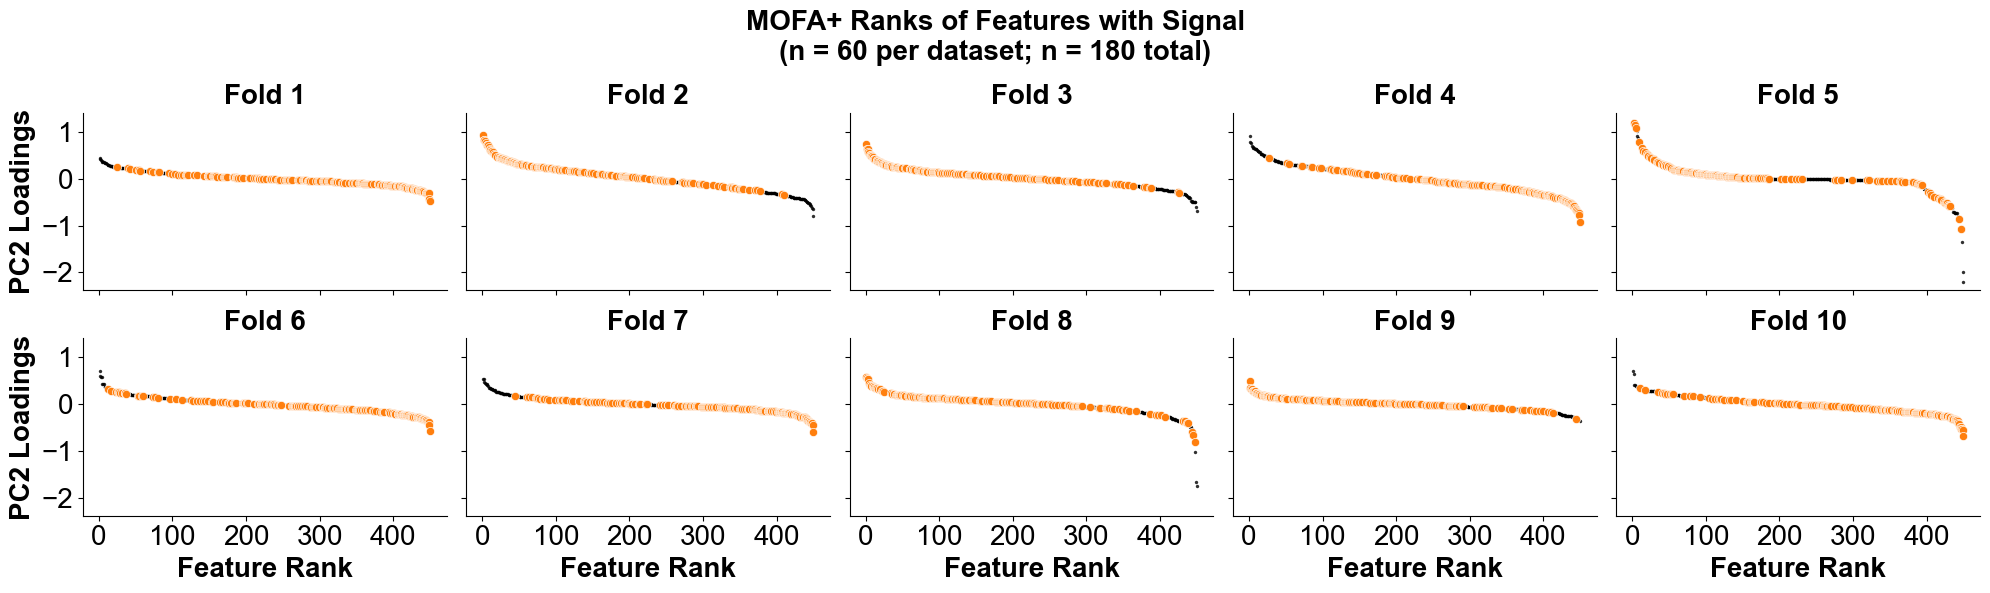

In [17]:
for n_induced in n_induced_idx:

    #get ground truth features (unique and shared per group)
    omic_feat_ids = np.concatenate(feat_induced_dict[n_induced])
    #print(len(omic_feat_ids))

    #plotting
    fig, axn = plt.subplots(2, 5, figsize=(20, 6), sharex=True, sharey=True)

    for ax, fold_ in zip(axn.flatten(), range(1, 11)):
        
        mofa_features_ = mofa_ranks[(fold_, n_induced)]
        #print(mofa_features_.shape)
        mofa_ord_ = mofa_train_ord[(fold_, n_induced)].copy()
        
        p_vals = {}
        pc_cols = [x for x in mofa_ord_.columns if 'PC' in x]
        for pc_ in pc_cols:
            f_, p_ = mannwhitneyu(mofa_ord_[mofa_ord_.groups == 'g0'].dropna(subset=[pc_])[pc_].values,
                                  mofa_ord_[mofa_ord_.groups != 'g0'].dropna(subset=[pc_])[pc_].values)
            p_vals[pc_] = round(p_, 5)
        best_pc = min(p_vals, key=p_vals.get)
        #print(p_vals, best_pc)

        best_ranks = mofa_features_.sort_values(by=best_pc, ascending=False)
        best_ranks = best_ranks.reset_index().rename(columns={'feature':'FeatureID'})
        best_ranks = best_ranks.reset_index().rename(columns={'index':'Rank'})
        best_ranks['Rank'] += 1
        best_ranks.set_index('FeatureID', inplace=True)
        
        sns.scatterplot(x='Rank', y=best_pc, s=5, color='black', alpha=0.8,
                        data=best_ranks, ax=ax, edgecolor='k')
        sns.scatterplot(x='Rank', y=best_pc, s=35, color='#ff7f0e', alpha=1,
                        data=best_ranks[best_ranks.index.isin(omic_feat_ids)], ax=ax)
        ax.set_xlabel('Feature Rank', fontsize=20, fontweight='bold', fontname='Arial')
        ax.set_ylabel('%s Loadings' % best_pc, fontsize=20, fontweight='bold', fontname='Arial')
        ax.set_title("Fold %s" % fold_, fontsize=20, fontweight='bold', fontname='Arial')
        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_fontsize(20)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_horizontalalignment('center')
            tick.set_fontsize(20)
        ax.locator_params(axis='x', nbins=5)
        ax.locator_params(axis='y', nbins=5)
        sns.despine()

    plt.suptitle('MOFA+ Ranks of Features with Signal\n(n = %s per dataset; n = %s total)' % (n_induced, n_induced*3),
                 fontsize=20, fontname='Arial', weight='bold')
    plt.tight_layout()

    if n_induced in [5, 20, 50]:
        plt.savefig("../../results/supp-fig3C-mofa-%sfeats.pdf" % n_induced,
                    dpi=600, bbox_inches='tight', 
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')
        plt.savefig("../../results/supp-fig3C-mofa-%sfeats.png" % n_induced,
                    dpi=600, bbox_inches='tight', 
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')
    plt.show()